In [38]:
# just to help me run on kaggle, not part of the actual code for the assignment, so please ignore this part
# to be deleted before submission (but if it is still here and not deleted, it is because I forgot to delete it, so please ignore it or comment it out, thank you!)
!git clone https://github.com/beckhamtoh/DSA4262.git
%cd "DSA4262/Individual Assignment 2"

Cloning into 'DSA4262'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 63 (delta 15), reused 47 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 4.45 MiB | 16.63 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/kaggle/working/DSA4262/Individual Assignment 2/DSA4262/Individual Assignment 2/DSA4262/Individual Assignment 2


# Imports

In [39]:
import os
import re
import json
import random
from dataclasses import dataclass

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, precision_score, recall_score, classification_report,
    confusion_matrix
)

# Configurations
np.random.seed(4262)
random.seed(4262)

TRAIN_PATH = "dreaddit-train.csv"
TEST_PATH  = "dreaddit-test.csv"

TARGET_COL = "label"
TEXT_COL   = "text"
GROUP_COL  = "subreddit"
CONF_COL   = "confidence"
ID_COL     = "id"

# Load data

In [40]:
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

train_df.head(2)


Train shape: (2838, 116)
Test shape : (715, 116)


,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.125,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857


In [41]:
# check all the columns in the train dataset
print("Columns in train dataset:", train_df.columns.tolist())


Columns in train dataset: ['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tentat', 'lex_liwc_certain', 'le

In [42]:
# check the distribution of the target variable
train_df[TARGET_COL] = train_df[TARGET_COL].astype(int)
test_df[TARGET_COL]  = test_df[TARGET_COL].astype(int)

print(train_df[TARGET_COL].value_counts())

label
1    1488
0    1350
Name: count, dtype: int64


# Exploratory Data Analysis

## Class balance

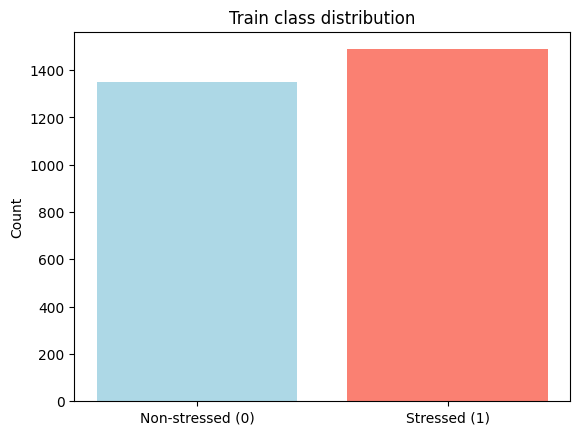

In [43]:
counts = train_df[TARGET_COL].value_counts().sort_index()
plt.figure()
plt.bar(["Non-stressed (0)", "Stressed (1)"], counts.values, color=["lightblue", "salmon"])
plt.title("Train class distribution")
plt.ylabel("Count")
plt.show()

## Post length distribution

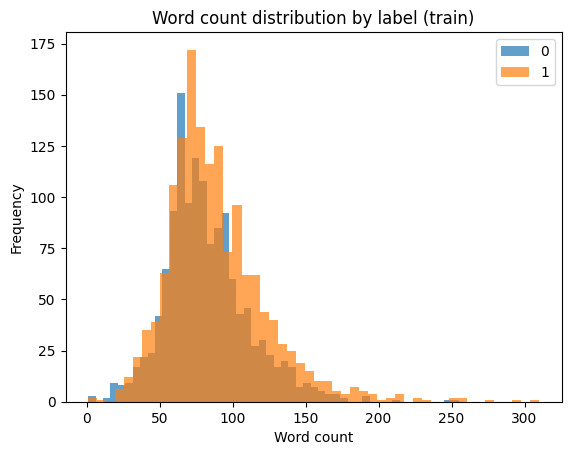

In [44]:
train_df["word_count"] = train_df[TEXT_COL].str.split().apply(len)

plt.figure()
plt.hist(train_df.loc[train_df[TARGET_COL] == 0, "word_count"], bins=50, alpha=0.7, label="0")
plt.hist(train_df.loc[train_df[TARGET_COL] == 1, "word_count"], bins=50, alpha=0.7, label="1")
plt.title("Word count distribution by label (train)")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Subreddit breakdown + stressed rate

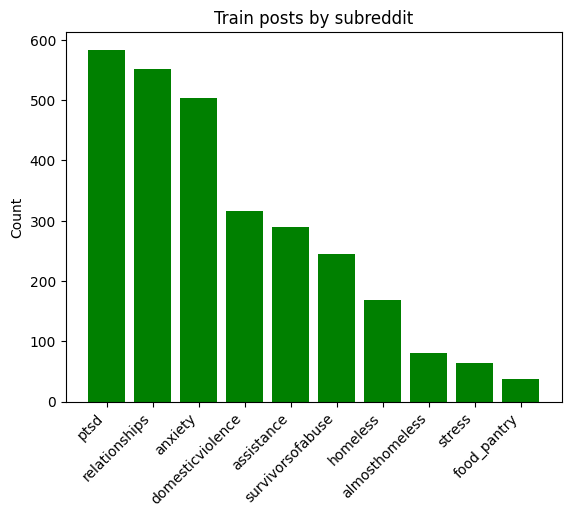

In [45]:
sub_counts = train_df[GROUP_COL].value_counts()

plt.figure()
plt.bar(sub_counts.index, sub_counts.values, color="green")
plt.title("Train posts by subreddit")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.show()

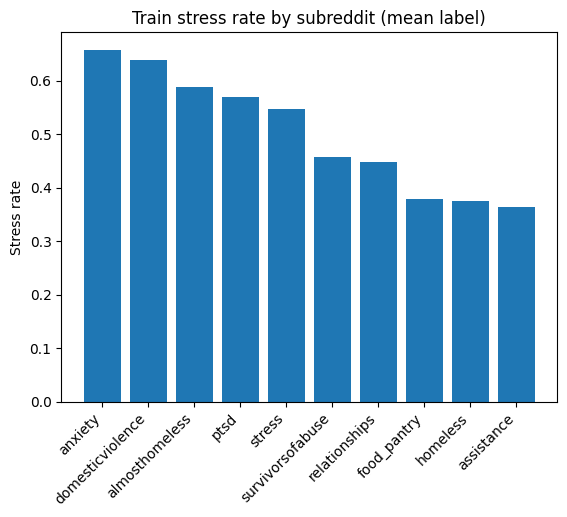

In [46]:
sub_stress_rate = train_df.groupby(GROUP_COL)[TARGET_COL].mean().sort_values(ascending=False)

plt.figure()
plt.bar(sub_stress_rate.index, sub_stress_rate.values)
plt.title("Train stress rate by subreddit (mean label)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Stress rate")
plt.show()

## Label confidence distribution

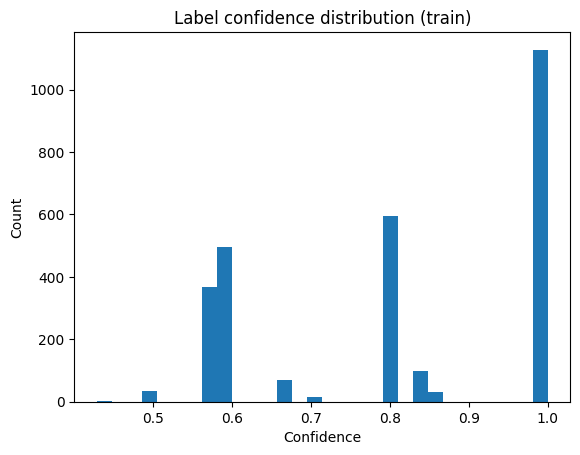

In [47]:
plt.figure()
plt.hist(train_df[CONF_COL].dropna(), bins=30)
plt.title("Label confidence distribution (train)")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()

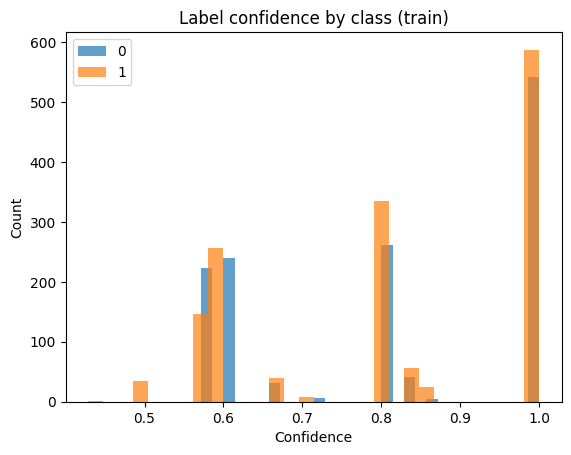

In [48]:
plt.figure()
plt.hist(train_df.loc[train_df[TARGET_COL]==0, CONF_COL].dropna(), bins=30, alpha=0.7, label="0")
plt.hist(train_df.loc[train_df[TARGET_COL]==1, CONF_COL].dropna(), bins=30, alpha=0.7, label="1")
plt.title("Label confidence by class (train)")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.legend()
plt.show()

# Stress in each subreddit

subreddit
anxiety             0.658052
domesticviolence    0.639241
almosthomeless      0.587500
ptsd                0.568493
stress              0.546875
survivorsofabuse    0.457143
relationships       0.447464
food_pantry         0.378378
homeless            0.375000
assistance          0.363322
Name: label, dtype: float64


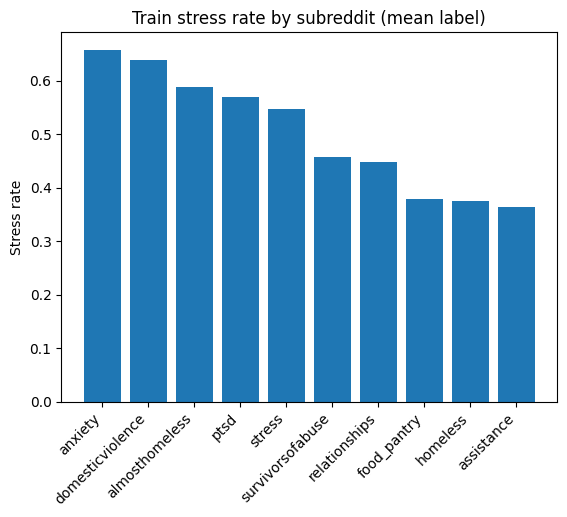

In [49]:
# check for stress rate in each subreddit
sub_stress_rate = train_df.groupby(GROUP_COL)[TARGET_COL].mean().sort_values(ascending=False)
print(sub_stress_rate)

# plot the stress rate by subreddit
plt.figure()
plt.bar(sub_stress_rate.index, sub_stress_rate.values)
plt.title("Train stress rate by subreddit (mean label)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Stress rate")
plt.show()

# Build feature lists
this is so we can automatically detect numeric feature columns so that it works even if column order is different for the train and test data

In [50]:
def add_basic_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["word_count"] = df[TEXT_COL].str.split().apply(len)
    return df

train_df = add_basic_features(train_df)
test_df  = add_basic_features(test_df)

In [51]:
# Numeric columns = all number-like columns except target
numeric_cols = []
for c in train_df.columns:
    if c in [TARGET_COL, TEXT_COL, GROUP_COL]:
        continue
    if pd.api.types.is_numeric_dtype(train_df[c]):
        numeric_cols.append(c)

# Sometimes IDs are numeric but not useful as features
for drop in [ID_COL]:
    if drop in numeric_cols:
        print(f"Dropping numeric column: {drop}")
        numeric_cols.remove(drop)

print("Num numeric feature cols:", len(numeric_cols))
numeric_cols[:]

Dropping numeric column: id
Num numeric feature cols: 111


['confidence',
 'social_timestamp',
 'social_karma',
 'syntax_ari',
 'lex_liwc_WC',
 'lex_liwc_Analytic',
 'lex_liwc_Clout',
 'lex_liwc_Authentic',
 'lex_liwc_Tone',
 'lex_liwc_WPS',
 'lex_liwc_Sixltr',
 'lex_liwc_Dic',
 'lex_liwc_function',
 'lex_liwc_pronoun',
 'lex_liwc_ppron',
 'lex_liwc_i',
 'lex_liwc_we',
 'lex_liwc_you',
 'lex_liwc_shehe',
 'lex_liwc_they',
 'lex_liwc_ipron',
 'lex_liwc_article',
 'lex_liwc_prep',
 'lex_liwc_auxverb',
 'lex_liwc_adverb',
 'lex_liwc_conj',
 'lex_liwc_negate',
 'lex_liwc_verb',
 'lex_liwc_adj',
 'lex_liwc_compare',
 'lex_liwc_interrog',
 'lex_liwc_number',
 'lex_liwc_quant',
 'lex_liwc_affect',
 'lex_liwc_posemo',
 'lex_liwc_negemo',
 'lex_liwc_anx',
 'lex_liwc_anger',
 'lex_liwc_sad',
 'lex_liwc_social',
 'lex_liwc_family',
 'lex_liwc_friend',
 'lex_liwc_female',
 'lex_liwc_male',
 'lex_liwc_cogproc',
 'lex_liwc_insight',
 'lex_liwc_cause',
 'lex_liwc_discrep',
 'lex_liwc_tentat',
 'lex_liwc_certain',
 'lex_liwc_differ',
 'lex_liwc_percept',
 'le

# Model Pipeline

In [52]:
text_transformer = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 2),
    min_df=2,
    max_features=200000
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("text", text_transformer, TEXT_COL),
        ("num", numeric_transformer, numeric_cols),
    ],
    remainder="drop"
)

clf = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    n_jobs=None,
    solver="liblinear"  # stable for sparse + smaller datasets
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", clf)
])

## Baseline 1: Majority clasiffier

In [53]:
y_train = train_df[TARGET_COL].values
majority = int(pd.Series(y_train).mode()[0])

y_pred_majority = np.full_like(y_train, fill_value=majority)
print("Majority label:", majority)
print("Train F1 (majority baseline):", f1_score(y_train, y_pred_majority))

Majority label: 1
Train F1 (majority baseline): 0.6879334257975035


## Baseline 2: basic TF-IDF + Logistic regression (w/o numeric features)

In [54]:
baseline_model = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced", solver="liblinear"))
])

baseline_model.fit(train_df[TEXT_COL], y_train)

test_pred = baseline_model.predict(test_df[TEXT_COL])
print("Test F1 (text-only baseline):", f1_score(test_df[TARGET_COL], test_pred))
print(classification_report(test_df[TARGET_COL], test_pred, digits=3))

Test F1 (text-only baseline): 0.7362924281984334
              precision    recall  f1-score   support

           0      0.726     0.668     0.696       346
           1      0.710     0.764     0.736       369

    accuracy                          0.717       715
   macro avg      0.718     0.716     0.716       715
weighted avg      0.718     0.717     0.717       715



## CV and hyperparameter tuning

In [55]:
X = train_df.copy()
y = train_df[TARGET_COL].values

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=4262)

param_grid = {
    "preprocess__text__ngram_range": [(1,1), (1,2)],
    "preprocess__text__min_df": [2, 5],
    "clf__C": [0.25, 0.5, 1.0, 2.0, 4.0]
}

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs.fit(X, y)

print("Best CV F1:", gs.best_score_)
print("Best params:", gs.best_params_)
best_model = gs.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV F1: 0.7845353831401922
Best params: {'clf__C': 2.0, 'preprocess__text__min_df': 2, 'preprocess__text__ngram_range': (1, 1)}


## Threshold tuning
Instead of the default threshold of 0.5, we shall choose a threshold that maximises the cross validation F1 score

In [56]:
def tune_threshold_cv(model, X, y, cv, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)

    thr_scores = {t: [] for t in thresholds}

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_va)[:, 1]

        for t in thresholds:
            pred = (proba >= t).astype(int)
            thr_scores[t].append(f1_score(y_va, pred))

    mean_scores = {t: float(np.mean(scores)) for t, scores in thr_scores.items()}
    best_t = max(mean_scores, key=mean_scores.get)
    return best_t, mean_scores

thresholds = np.linspace(0.05, 0.95, 19)
best_thr, thr_to_f1 = tune_threshold_cv(best_model, X, y, cv, thresholds=thresholds)

best_thr, thr_to_f1[best_thr]

(np.float64(0.39999999999999997), 0.7913967094995236)

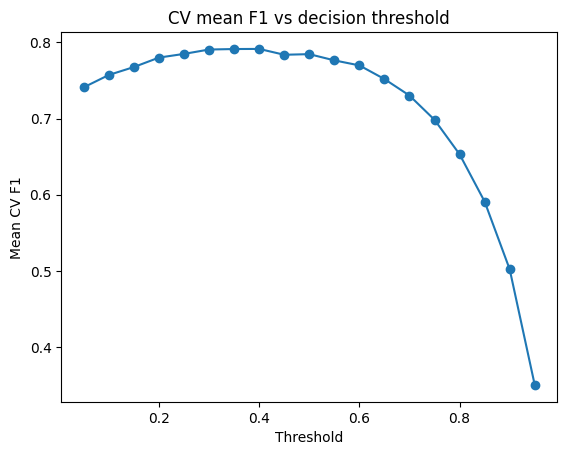

Chosen threshold: 0.39999999999999997


In [57]:
# Plot threshold vs CV F1
ts = sorted(thr_to_f1.keys())
fs = [thr_to_f1[t] for t in ts]

plt.figure()
plt.plot(ts, fs, marker="o")
plt.title("CV mean F1 vs decision threshold")
plt.xlabel("Threshold")
plt.ylabel("Mean CV F1")
plt.show()

print("Chosen threshold:", best_thr)

# Training and evaluation of test

In [58]:
best_model.fit(train_df, train_df[TARGET_COL].values)

test_proba = best_model.predict_proba(test_df)[:, 1]
test_pred  = (test_proba >= best_thr).astype(int)

print("TEST F1:", f1_score(test_df[TARGET_COL].values, test_pred))
print("TEST Precision:", precision_score(test_df[TARGET_COL].values, test_pred))
print("TEST Recall:", recall_score(test_df[TARGET_COL].values, test_pred))
print("\nClassification report:\n", classification_report(test_df[TARGET_COL].values, test_pred, digits=3))

TEST F1: 0.7812895069532237
TEST Precision: 0.7322274881516587
TEST Recall: 0.8373983739837398

Classification report:
               precision    recall  f1-score   support

           0      0.795     0.673     0.729       346
           1      0.732     0.837     0.781       369

    accuracy                          0.758       715
   macro avg      0.764     0.755     0.755       715
weighted avg      0.763     0.758     0.756       715



In [59]:
cm = confusion_matrix(test_df[TARGET_COL].values, test_pred)
cm

array([[233, 113],
       [ 60, 309]])

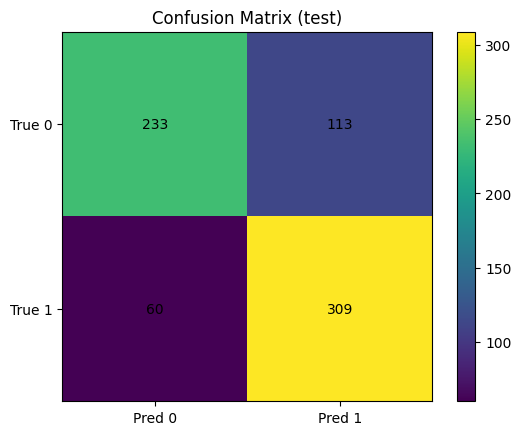

In [60]:
# Simple confusion matrix display
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (test)")
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()

# Analyses

## Analysis 1: F1 score by subreddit

In [61]:
def f1_by_group(df, y_true, y_pred, group_col=GROUP_COL):
    out = []
    for g, sub in df.groupby(group_col):
        yt = y_true[sub.index]
        yp = y_pred[sub.index]
        out.append({"subreddit": g, "n": len(sub), "f1": f1_score(yt, yp)})
    return pd.DataFrame(out).sort_values("f1", ascending=False)

y_true_test = test_df[TARGET_COL].values
group_f1 = f1_by_group(test_df, y_true_test, test_pred)

group_f1

,subreddit,n,f1
4,food_pantry,6,1.000000
3,domesticviolence,72,0.875000
8,stress,14,0.857143
6,ptsd,127,0.828402
1,anxiety,147,0.826531
0,almosthomeless,19,0.750000
2,assistance,66,0.739130
9,survivorsofabuse,70,0.732394
7,relationships,142,0.650407
5,homeless,52,0.615385


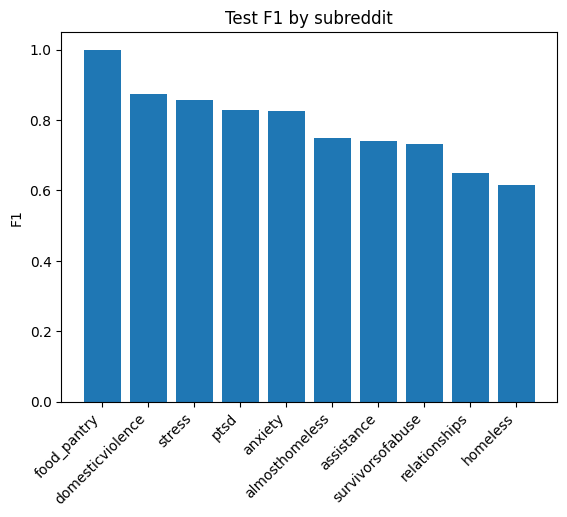

In [62]:
plt.figure()
plt.bar(group_f1["subreddit"], group_f1["f1"])
plt.title("Test F1 by subreddit")
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1")
plt.show()

## Analysis 2: "Confidently wrong" cases

In [63]:
analysis_df = test_df[[ID_COL, GROUP_COL, TEXT_COL, TARGET_COL, CONF_COL]].copy()
analysis_df["proba_stress"] = test_proba
analysis_df["pred"] = test_pred
analysis_df["correct"] = (analysis_df["pred"] == analysis_df[TARGET_COL])

analysis_df.head(3)

,id,subreddit,text,label,confidence,proba_stress,pred,correct
0,896,relationships,"Its like that, if you want or not.“ ME: I have...",0,0.8,0.093007,0,True
1,19059,anxiety,I man the front desk and my title is HR Custom...,0,1.0,0.212557,0,True
2,7977,ptsd,We'd be saving so much money with this new hou...,1,1.0,0.528119,1,True


### Top confident False Positives

In [64]:
fp = analysis_df[(analysis_df["pred"] == 1) & (analysis_df[TARGET_COL] == 0)].copy()
fp = fp.sort_values("proba_stress", ascending=False)

fp[[ID_COL, GROUP_COL, "proba_stress", TARGET_COL, "pred", CONF_COL, TEXT_COL]].head(10)

,id,subreddit,proba_stress,label,pred,confidence,text
540,562,ptsd,0.975898,0,1,1.000000,What are you thankful for? For me: Today I'm f...
633,44969,survivorsofabuse,0.973089,0,1,0.800000,But it took me months afterward to end it. I r...
50,49500,relationships,0.941604,0,1,0.600000,None of the issues we discuss get addressed. 6...
474,1939,anxiety,0.937769,0,1,0.800000,They looked nothing like my growths. She told ...
256,998,domesticviolence,0.913065,0,1,0.666667,This internet ban subsequently resulted in me ...
197,25271,anxiety,0.896294,0,1,0.600000,I’m asking yall how can I live life properly?...
317,28337,survivorsofabuse,0.887713,0,1,0.800000,"He broke up with me, accused me of lying about..."
604,28212,anxiety,0.884825,0,1,1.000000,"My flaws seemed huge to me, and I assumed ever..."
654,13106,anxiety,0.883424,0,1,0.600000,"Almost decided to live in my car, live with a ..."
241,51387,ptsd,0.875239,0,1,1.000000,I feel like I am just being written off becaus...


### Top confident False Negatives

In [65]:
fn = analysis_df[(analysis_df["pred"] == 0) & (analysis_df[TARGET_COL] == 1)].copy()
fn = fn.sort_values("proba_stress", ascending=True)

fn[[ID_COL, GROUP_COL, "proba_stress", TARGET_COL, "pred", CONF_COL, TEXT_COL]].head(10)

,id,subreddit,proba_stress,label,pred,confidence,text
175,2270,relationships,0.019417,1,0,0.600000,"We met about 2.5 years ago, both somewhat fres..."
507,1631,stress,0.058243,1,0,0.666667,"We had 2 classes together, so we spent a few h..."
181,661,relationships,0.070502,1,0,0.600000,"For instance, there was a show on netflix that..."
324,1123,relationships,0.071680,1,0,0.600000,"That's it. My mom made me delete it and said ""..."
711,2212,relationships,0.076185,1,0,0.571429,Also I can't think about both of them without ...
680,2118,relationships,0.090764,1,0,0.000000,"So I met this girl last year, in November. Alt..."
174,1569,relationships,0.107466,1,0,0.666667,He is our little angel and we are both gaga fo...
435,46814,relationships,0.108892,1,0,0.600000,"Moving on to the following workday, I went ove..."
516,37177,almosthomeless,0.119435,1,0,0.571429,She ended up relapsing on drugs and said that ...
12,53256,ptsd,0.121042,1,0,1.000000,PTSD is life changing for the worse. Every day...


## Analysis 3: Whether the "label confidence" predicts errors

In [66]:
tmp = analysis_df.dropna(subset=[CONF_COL]).copy()
tmp["error"] = (~tmp["correct"]).astype(int)

# Bin confidence into quartiles
tmp["conf_bin"] = pd.qcut(tmp[CONF_COL], q=4, duplicates="drop")

bin_stats = tmp.groupby("conf_bin")["error"].mean().reset_index()
bin_stats

/tmp/ipykernel_55/292247881.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = tmp.groupby("conf_bin")["error"].mean().reset_index()


,conf_bin,error
0,"(-0.001, 0.6]",0.362550
1,"(0.6, 0.8]",0.259036
2,"(0.8, 1.0]",0.130872


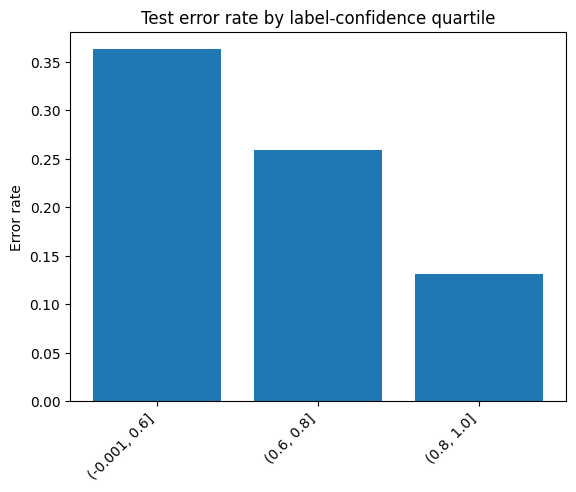

In [67]:
plt.figure()
plt.bar(bin_stats["conf_bin"].astype(str), bin_stats["error"])
plt.title("Test error rate by label-confidence quartile")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Error rate")
plt.show()

# Interpretability

## helper functions

In [68]:
def get_feature_names_from_column_transformer(ct: ColumnTransformer):
    feature_names = []

    for name, trans, cols in ct.transformers_:
        if name == "remainder":
            continue

        if hasattr(trans, "get_feature_names_out"):
            # e.g., TFIDF
            if isinstance(cols, str):
                # single column name
                fn = list(trans.get_feature_names_out())
            else:
                fn = list(trans.get_feature_names_out(cols))
            feature_names.extend([f"{name}__{x}" for x in fn])

        else:
            # numeric pipeline: use the column names directly
            if isinstance(cols, str):
                feature_names.append(f"{name}__{cols}")
            else:
                feature_names.extend([f"{name}__{c}" for c in cols])

    return feature_names

ct = best_model.named_steps["preprocess"]
clf = best_model.named_steps["clf"]

feat_names = get_feature_names_from_column_transformer(ct)
coefs = clf.coef_.ravel()

len(feat_names), len(coefs)

(6198, 6198)

In [69]:
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df = coef_df.sort_values("coef", ascending=False)

print("Top features pushing towards STRESS (label=1):")
display(coef_df.head(20))

print("\nTop features pushing towards NON-STRESS (label=0):")
display(coef_df.tail(20).sort_values("coef"))

Top features pushing towards STRESS (label=1):


,feature,coef
902,text__cannot,2.014935
5362,text__tell,1.975258
3573,text__need,1.814162
1561,text__did,1.756529
1935,text__even,1.739291
1435,text__days,1.727652
3777,text__over,1.671670
3209,text__literally,1.650228
3359,text__me,1.649037
1718,text__dr,1.611276



Top features pushing towards NON-STRESS (label=0):


,feature,coef
6059,text__years,-1.951227
5404,text__that,-1.938742
2147,text__finally,-1.820991
3415,text__met,-1.633052
3300,text__make,-1.535851
529,text__avoid,-1.530428
5929,text__when,-1.508955
1945,text__everyone,-1.431789
4908,text__sleeping,-1.419983
686,text__bit,-1.399805


## predicted probability w strongest global features

In [70]:
def show_case(df_row):
    row_df = pd.DataFrame([df_row])
    proba = best_model.predict_proba(row_df)[:, 1][0]
    pred = int(proba >= best_thr)
    return proba, pred

# Example: take first false negative and inspect
example_row = fn.iloc[0]
proba, pred = show_case(example_row)
print("Proba stress:", proba, "Pred:", pred, "True:", int(example_row[TARGET_COL]))
print("Subreddit:", example_row[GROUP_COL], "Confidence label:", example_row[CONF_COL])
print("\nTEXT:\n", example_row[TEXT_COL])

ValueError: columns are missing: {'lex_liwc_adverb', 'lex_liwc_Authentic', 'lex_liwc_leisure', 'lex_liwc_insight', 'lex_liwc_posemo', 'lex_liwc_Colon', 'lex_liwc_focusfuture', 'lex_liwc_interrog', 'lex_dal_min_pleasantness', 'lex_liwc_Quote', 'lex_liwc_friend', 'lex_liwc_hear', 'lex_liwc_SemiC', 'lex_liwc_Dash', 'lex_liwc_Analytic', 'lex_liwc_risk', 'lex_liwc_female', 'lex_liwc_cogproc', 'lex_liwc_OtherP', 'lex_liwc_AllPunc', 'lex_liwc_differ', 'lex_liwc_they', 'lex_liwc_WPS', 'lex_liwc_ingest', 'lex_liwc_Clout', 'lex_liwc_prep', 'lex_liwc_number', 'lex_liwc_verb', 'lex_liwc_bio', 'lex_liwc_home', 'social_karma', 'lex_liwc_netspeak', 'lex_dal_max_activation', 'lex_liwc_Sixltr', 'lex_liwc_achieve', 'lex_liwc_see', 'social_num_comments', 'lex_dal_avg_activation', 'lex_dal_avg_pleasantness', 'lex_liwc_negemo', 'lex_liwc_anger', 'lex_liwc_WC', 'lex_liwc_body', 'lex_liwc_sad', 'lex_dal_min_imagery', 'lex_liwc_relativ', 'lex_liwc_swear', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_Parenth', 'word_count', 'lex_liwc_work', 'lex_liwc_space', 'social_timestamp', 'lex_liwc_male', 'lex_liwc_negate', 'sentiment', 'lex_liwc_cause', 'lex_liwc_motion', 'lex_liwc_focuspresent', 'lex_liwc_article', 'syntax_ari', 'lex_liwc_Comma', 'lex_liwc_power', 'lex_dal_avg_imagery', 'lex_liwc_adj', 'lex_liwc_shehe', 'lex_liwc_affiliation', 'lex_liwc_Exclam', 'lex_liwc_Tone', 'lex_liwc_death', 'lex_liwc_auxverb', 'lex_liwc_compare', 'lex_liwc_nonflu', 'lex_liwc_drives', 'lex_liwc_sexual', 'lex_liwc_Period', 'lex_liwc_social', 'lex_liwc_reward', 'lex_liwc_focuspast', 'lex_liwc_Dic', 'lex_liwc_percept', 'lex_liwc_assent', 'social_upvote_ratio', 'lex_liwc_relig', 'lex_liwc_time', 'lex_liwc_pronoun', 'lex_liwc_discrep', 'lex_liwc_certain', 'lex_liwc_function', 'lex_liwc_filler', 'lex_liwc_quant', 'lex_liwc_anx', 'lex_liwc_tentat', 'lex_liwc_money', 'lex_dal_max_pleasantness', 'lex_liwc_Apostro', 'lex_liwc_i', 'lex_liwc_QMark', 'lex_liwc_ipron', 'lex_liwc_conj', 'lex_dal_min_activation', 'lex_liwc_informal', 'lex_liwc_affect', 'lex_liwc_ppron', 'lex_liwc_health', 'syntax_fk_grade', 'lex_dal_max_imagery', 'lex_liwc_family', 'lex_liwc_feel'}